In [1]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, norm #, inv, eigsh

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc

#rc('text', usetex=False) # para usar latex en matplotlib

from celluloid import Camera #pip install celluloid si es que no lo tienen.

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra

**Integrantes:** Sebastián Cobaise, Arturo Lazcano, Benjamin Tardy
**Grupo: 5**

# Laboratorio 3

El objetivo de esta sesión es aplicar el método de diferencias finitas en varias variables para problemas de primer orden. Para ello, se estudiará la ecuación de advección de primer orden y la ecuación de Burgers, un modelo no lineal que permite modelar el tráfico vehicular.

## Ecuación de Advección

Sea un intervalo acotado $\Omega=\left(  a,b\right)  \subseteq\mathbb{R}$ y $\alpha>0$. Considere la el problema de advección de primer orden dado por 
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+\alpha\dfrac{\partial u}{\partial x}= &
0 & \qquad \text{para }\left(  t,x\right)  \in\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right)  & \qquad \text{para }x\in\Omega
\end{array}
\right\} \qquad (1)
\end{equation}
$$

Existen varios esquemas numéricos basados en diferencias finitas para analizar esta ecuación, pero tienen diversas particularidades. Elegir uno de ellos por sobre otro es una tarea difícil.

Sean $\Delta t>0$ y $N\in\mathbb{N}$. Definiendo $t_{n}=n\Delta t$ para $n\in\mathbb{N} \cup \left\{  0\right\}  $, $\Delta x=\dfrac{b-a}{N+1}$ y $x_{j}=a+j\Delta x$, para $j\in\{0,1,\ldots,N+1\}$; se denota $u_{j}^{n} = u\left(  t_{n},x_{j}\right)$. Los esquemas de tipo Lax son algunos de los más usados para resolver este tipo de problemas, siendo los más simples los esquemas de Lax-Friedrichs y de Lax-Wendroff, dados por

**a.** Lax-Friedrichs
$$
\dfrac{2u_{j}^{n+1}-\left(  u_{j+1}^{n}+u_{j-1}^{n}\right)  }{2\Delta
t}+\alpha\dfrac{u_{j+1}^{n}-u_{j-1}^{n}}{2\Delta x}=0
$$


**b.** Lax-Wendroff
$$
\dfrac{u_{j}^{n+1}-u_{j}^{n}}{\Delta t}+\alpha\dfrac{u_{j+1}^{n}-u_{j-1}^{n}%
}{2\Delta x}-\alpha^{2}\Delta t\dfrac{u_{j+1}^{n}-2u_{j}^{n}+u_{j-1}^{n}%
}{2\Delta x^2}=0
$$

### Ejercicio 1

Sean $\alpha,T>0$. Considere el siguiente problema
$$
\begin{array}{rll}
\displaystyle{\frac{\partial u}{\partial t}+\alpha\frac{\partial u}{\partial x}}  &
=0 & \qquad\text{para }\left(  t,x\right)  \in(0,T)\times\left(  0,1\right) \\
u(t,x+1)  &  =u(t,x) & \qquad\text{para }\left(  t,x\right)  \in\lbrack
0,T)\times\left[  0,1\right] \\
u\left(  0,x\right)   &  =u_{0}(x) & \qquad\text{para }x\in\left[  0,1\right]
\end{array}
$$

**a.** Programe una función que resuelva numéricamente esta ecuación por cada uno de los esquemas numéricos presentados anteriormente. Las entradas de cada programa deben ser $\alpha$, $\Delta t$, $N_{T}$, $N$ y $u_{0}$, donde $N_{T}$ es un entero tal que $N_{T}\Delta t=T$.

In [40]:
def resolver_adveccion(a, b, alpha, dt, NT, N, u0, esquema): 
    """Resuelve la ecuacion de adveccion $\partial_t u + \alpha \partial_x u = 0$ 
    con condiciones periodicas, en el dominio (a,b) y un intervalo de tiempo [0,T]. 
    ------- 
    Input: 
    - a: float 
        Extremo izquierdo del dominio 
    - b: float > a 
        Extremo derecho del dominio 
    - alpha: float 
    - dt: float 
        paso temporal para el que se resolvera la ecuacion 
    - NT: int 
        Cumple NT * dt = T 
    - N: int 
        Cantidad de subintervalos en que se discretizara el dominio. El paso espacial sera 1/N. 
    - u0: callable 
        Funcion con la condicion inicial del problema 
    - esquema: {'LW', 'LF'} 
        Esquema usado para resolver la ecuacion. 
        - 'LW': Lax Wendroff 
        - 'LF': Lax Friedrich 
     
    ------- 
    Output: 
    - x: numpy array, largo N+1 
        Discretizacion del dominio donde se calculo la solucion 
    - U: numpy array de (N+2)x(NT+1) 
        Solucion, evaluada en la grilla en cada paso de tiempo. U[j,n] es la solucion en x_j,  
        en el tiempo t = n*dt. 
    ------- 
    """ 
 
    deltax = (b-a)/(N+1)              #Se definen las variables a utilizar con los parámetros dados 
    x = [] 
    tiempo = [] 
    T = NT * dt 
    U = np.zeros((N+2,NT+1)) 
    ci = [] 
    K1 = (deltax - alpha*dt)/(2*deltax)    #Constantes que aparecen en el esquema LF 
    K2 = (deltax + alpha*dt)/(2*deltax) 
     
    for j in range(0,N+2):       #Se agregan los puntos que conforman el espacio discretizado 
        xj = a + j*deltax 
        x.append(xj) 
        tj = j*dt             #Se agregan los puntos que coforman al tiempo discretizado 
        tiempo.append(tj) 
        ci.append(u0(xj))     #Se evalua la condición inicial a lo largo del espacio 
     
    U[:,0] = ci 
 
    if esquema == "LF":                                  #Se define esquema LF 
        for t in range(1,NT+1): 
            for j in range(0,N+2): 
                presente = U[:,int(t-1)] 
                if j == 0: 
                    Ujnn = presente[int(j+1)]*K1 + presente[-2]*K2 
                if j == N+1: 
                    Ujnn = presente[int(1)]*K1 + presente[N]*K2 
                else: 
                    Ujnn = presente[int(j+1)]*K1 + presente[int(j-1)]*K2   
                U[j,t]  = Ujnn  
 
       
    if esquema == "LW": 
        for t in range(1,NT+1): 
            for j in range(0,N+2): 
                presente = U[:,int(t-1)] 
                if j == 0: 
                    Ujnn = presente[j] - (((alpha)*dt)/((2*deltax)))*(presente[int(j+1)]  - presente[-1]) + (((dt/deltax)**2)/2)*(presente[int(j+1)] + presente[-1] -2*presente[j]) 
                if j == N+1: 
                    Ujnn = presente[j] - (((alpha)*dt)/((2*deltax)))*(presente[int(0)]  - presente[N]) + (((dt/deltax)**2)/2)*(presente[int(0)] + presente[N] -2*presente[N+1]) 
                else: 
                    Ujnn = presente[j] - (((alpha)*dt)/((2*deltax)))*(presente[int(j+1)]  - presente[int(j-1)]) + (((dt/deltax)**2)/2)*(presente[int(j+1)] + presente[int(j-1)] -2*presente[j])   
                U[j,t]  = Ujnn   
 
 
    return x, U

**b.** Considere $\Delta x=0.01$, $\alpha=1$, $\Delta t = \frac{\lambda}{\alpha}\Delta x$, $T=2$ y la condición inicial $u_{0}\left(  x\right)  =\sin\left(  2\pi x\right)  $. Calcule la solución numérica para $\lambda\in\left\{  0.8,0.4,0.1\right\}  $ y, para cada valor de $\lambda$, grafique las soluciones numéricas de cada método junto con la solución exacta.

Discuta los resultados en función de $\lambda$ y del tipo de
ecuación equivalente asociada a cada esquema.

**Indicación:** Utilice animaciones para observar la evolución de las soluciones.

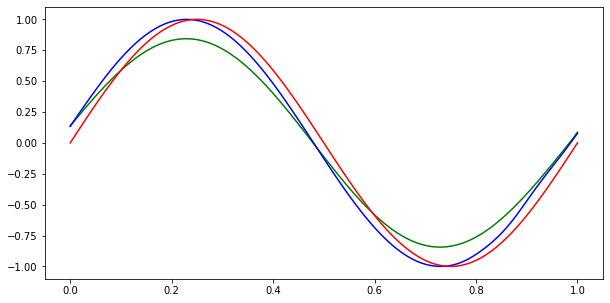

In [42]:
u0 = lambda x : np.sin(2*np.pi*x) 
 
alpha = 1 
u = lambda x,t : u0(x-alpha*t) 
dx = 0.01 
dt08 = 0.8*dx 
dt04 = 0.4*dx 
dt01 = 0.1*dx 
T = 2 
NT08 = int(T/dt08) 
NT04 = int(T/dt04) 
NT01 = int(T/dt01) 
N = int(1/dx) 
 
 
 
x,ULF = resolver_adveccion(0,1,alpha,dt08,NT08,N,u0,"LF") 
x,ULW = resolver_adveccion(0,1,alpha,dt08,NT08,N,u0,"LW") 
 

def animar_soluciones(x,ULF, ULW, alpha, dt, NT, N, u): 
    """ 
    -------- 
    Input: 
    - x: array 
        Discretizacion de [0,1] 
    - ULF, ULW: array 
        Soluciones obtenidas con resolver_adveccion con los metodos LF, LW y UW respect. 
    - u: callable 
        Funcion que entrega la solucion real de la ecuacion. 
    -------- 
    """ 
     
    fig = plt.figure(figsize = (10,5)) 
    #Definir parámetros de la figura 
     
    #Inicializar animacion 
    camera = Camera(fig) 
     
    #Comenzar a graficar 
    for n in range(NT+1): 
        sol=[] 
        for i in x: 
            sol.append(u(i,n*dt))  
        #Graficos 
        plt.plot(x,(ULF[:,n]),c="g") 
        plt.plot(x,(ULW[:,n]),c="b") 
        plt.plot(x,sol,c="r") 
        #Toma foto 
        camera.snap() 
     
    #Exportar animaciones 
    anim = camera.animate(blit=False, interval=100) 
    anim.save('discretizacion.gif', writer='pillow', fps=10)

animar_soluciones(x,ULF, ULW, alpha, dt08, NT08, N, u)

Con respecto a la animación, se puede apreciar que el esquema LW (azul) aproxima de mejor manera a la solución original conforme pasa el tiempo

**c.** Repita lo anterior, considerando ahora la condición inicial
$$
u_{0}\left(  x\right)  =\left\{
\begin{array}
[c]{cl}
1/2 & \text{si }x\in\left[  0.3,0.7\right]  \\
-1/2 & \text{si }x\in\left[  0,1\right]  \setminus [  0.3,0.7]
\end{array}
\right.
$$

**Indicación.** Considere una extensión periódica de $u_{0}$, la cual puede ser útil para graficar la solución real.

## Ecuación de Burgers aplicado al tráfico vehicular

Uno de los problemas más complicados en la ingeniería de transporte es modelar el funcionamiento de los semáforos. Un modelo continuo para el tráfico vehicular en una única pista, donde no se permite adelantar un automóvil, está dado por la ecuación de Burgers. Asuma que la velocidad máxima está dada por $V$ y la densidad de vehículos por unidad de longitud está dada por $D>0$. Si la velocidad $v$ y la densidad $\rho$ se relacionan mediante la ley
$$
v=V\left(  1-\dfrac{\rho}{D}\right)  \qquad \text{ para }\rho\in\left[
0,D\right]
$$
y se define $u=1-\dfrac{2\rho}{D}$, se puede probar que se cumple la ecuación dada por
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+u\dfrac{\partial u}{\partial x}= &
0 & \qquad \text{para }\left(  t,x\right)  \in\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right)  & \qquad \text{para }x\in\Omega
\end{array}
\right\} \qquad (2)
\end{equation}
$$
donde $-1\leq u\leq1$. El valor $u=-1$ significa que los vehículos no se mueven, pues se llegó a la densidad máxima, mientras que el valor $u=1$ representa que un vehículo que pase por la vía puede ir a la velocidad máxima permitida, puesto que la vía está totalmente vacía.

A diferencia de la primera ecuación analizada en este laboratorio, no es posible obtener una forma explícita para la solución de la ecuación de Burgers, aunque puede probarse que
$$
u\left(  t,x\right)  =u_{0}\left(  x-u\left(  t,x\right)  t\right)
$$
es una expresión implícita para la solución. Además, esta ecuación es no lineal, por lo que aplicar los mismos esquemas antes estudiados requiere un estudio más profundo.

Otra forma de escribir esta ecuación es
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  \dfrac
{1}{2}u^{2}\right]  = & 0 &\qquad \text{ para }\left(  t,x\right)  \in
\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right) &\qquad \text{ para }x\in\Omega
\end{array}
\right\} \qquad (3)
\end{equation}
$$

la cual se conoce como forma conservativa de la ecuación de Burgers. Esta forma es sumamente útil para presentar los esquemas de Lax-Friedrichs y Lax-Wendroff aplicados para esta ecuación. En general, dichos esquemas se presentan para ecuaciones de la forma $\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  f\left(  u\right)  \right] =0$.

Definiendo $\lambda=\dfrac{\Delta t}{\Delta x}$ y $f_{j}^{n}=f(
u_{j}^{n})  $, se presentan los esquemas de Lax-Friedrichs y
Lax-Wendroff en su forma conservativa

$1)$ Lax Friedrichs conservativo:

    1) Paso 1:
$$
F_{j}^{n} = \frac{1}{2}(f_{j-1}^n + f_j^n) - \frac{1}{2\lambda}(u_j^n - u_{j-1}^n)
$$

    2) Paso 2:
$$
u_j^{n+1} = u_j^n - \lambda (F_{j+1}^n - F_j^n)
$$

$2)$ Lax-Wendroff conservativo (esquema de Richtmyer)
Es posible demostrar que estos esquemas son consistentes y convergentes, con
los mismos órdenes que en el caso lineal.

    1) Paso 1:
$$
u_{j+1/2}^n = \frac{1}{2}(u_{j+1}^n + u_j^n) - \frac{\lambda}{2}(f_{j+1}^n - f_j^n)
$$
$$
u_{j-1/2}^n = \frac{1}{2}(u_{j}^n + u_{j-1}^n) - \frac{\lambda}{2}(f_{j}^n - f_{j-1}^n)
$$

    2) Paso 2:
$$
u_{j}^{n+1} =u_{j}^{n}-\lambda\left(  f\left(  u_{j+1/2}^{n}\right)-f\left(  u_{j-1/2}^{n}\right)  \right)
$$

A continuación se simulará el efecto de un flujo de vehículos que entra a una calle a una velocidad mayor a la que tienen otros vehículos que circulan más adelante.

## Ejercicio 2

Sea $f$ una función de clase $\mathcal{C}^{1}$, $T>0$ y $a,b\in\mathbb{R}$, con $a<b$. Considere la ecuación.
$$
\begin{array}{rll}
\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  f\left(
u\right)  \right]   &  =0 & \qquad\text{para }\left(  t,x\right)  \in
(0,T)\times\left(  a,b\right)  \\
u\left(  t,a\right)   &  =u_{a} & \qquad\text{para }t\in\left(  0,T\right]  \\
u\left(  t,b\right)   &  =u_{b} & \qquad\text{para }t\in\left(  0,T\right]  \\
u\left(  0,x\right)   &  =u_{0}(x) & \qquad\text{para }x\in\left[  0,1\right]
\end{array}
$$

**a.** Implemente cada uno de los esquemas de Lax para resolver numéricamente esta ecuación mediante una función. Las entradas de cada programa deben ser la función $f$, $a$, $b$, las condiciones de frontera $u_{a}$ y $u_{b}$, $\Delta t>0$, $N_{T}\in\mathbb{N}$ tal que $N_{T}\Delta t=T$, $N\in\mathbb{N}$ como la cantidad de puntos interiores en su particion del intervalo $\left[  a,b\right]  $ y la condición inicial $u_{0}$ como un vector $\boldsymbol{u}_{0}=\left(  u_{j}^{0}\right)  \in\mathbb{R}^{N+2}$.

In [32]:
def resolver_ej2(f, a, b, ua, ub, dt, N_T, N, u0, esquema):
    
    U=np.zeros((N+2,N_T+1))
    
    h=(b-a)/(N+1)
    
    x=np.arange(a,b+h/2,h)
    
    lamb=dt/dx
    
    U[:,0]=u0
    
    if esquema=="LF":
        #iterar en el tiempo
        for t in range(1,N_T+1):
            #presente: tiempo actual para calcular el siguiente
            presente=U[:,t-1]
            #generar la solución en el nuevo tiempo
            nuevo=[]
            nuevo.append(ua)
            for i in range(1,N+1):
                #chantar el LF
                Fj=(1/2)*(f(presente[i-1])+f(presente[i]))-((1/(2*lamb))*(presente[i]-presente[i-1]))
                #Fjj es F_(j+1)^n
                Fjj=(1/2)*(f(presente[i])+f(presente[i+1]))-((1/(2*lamb))*(presente[i+1]-presente[i]))
                nuevo_valor=presente[i]-lamb*(Fjj-Fj)
                nuevo.append(nuevo_valor)
            nuevo.append(ub)
            U[:,t]=nuevo
        
    if esquema=="LW":
        #iterar en el tiempo
        for t in range(1,N_T+1):
            #presente: tiempo actual para calcular el siguiente
            presente=U[:,t-1]
            #generar la solución en el nuevo tiempo
            nuevo=[]
            nuevo.append(ua)
            for i in range(1,N+1):
                #chantar el LW
                u_mas_unmedio=(1/2)*(presente[i+1]+presente[i])-(lamb/2)*(f(presente[i+1])-f(presente[i]))
                u_menos_unmedio=(1/2)*(presente[i]+presente[i-1])-(lamb/2)*(f(presente[i])-f(presente[i-1]))
                nuevo_valor=presente[i]-lamb*(f(u_mas_unmedio)-f(u_menos_unmedio))
                nuevo.append(nuevo_valor)
            nuevo.append(ub)
            U[:,t]=nuevo  
    return x, U


**b.** Considere el dominio $\Omega=\left[  0,1\right]  $, $D=1$, las condiciones de frontera $u\left(  t,0\right)  =0.5$ y $u\left(  t,1\right)  =0$ para todo $t>0$ y la condición inicial dada por
$$
u_{0}\left(  x\right)  =\left\{
\begin{array}
[c]{cc}%
0.5 & \text{si }x<0.2\\
0 & \text{si }x\geq0.2
\end{array}
\right.
$$
Resuelva numéricamente la ecuación de Burgers para este caso usando los esquemas conservativos de Lax-Friedrichs y Lax-Wendroff para $T=2$, $\Delta x\in\left\{  0.01,0.005,0.002\right\}  $ y $\Delta t=0.5\Delta x$. Grafique la velocidad y densidad apropiadamente.

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


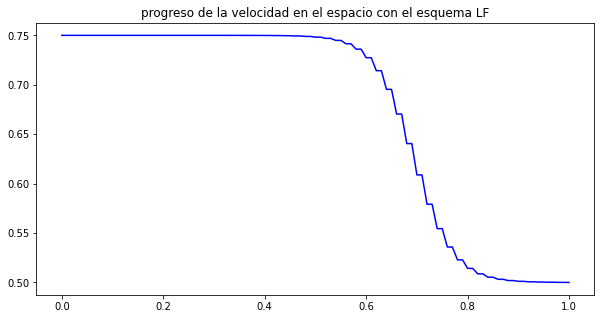

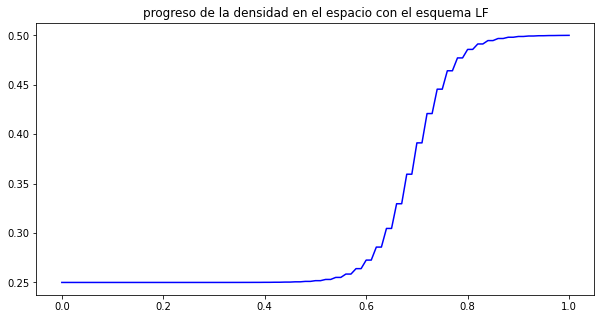

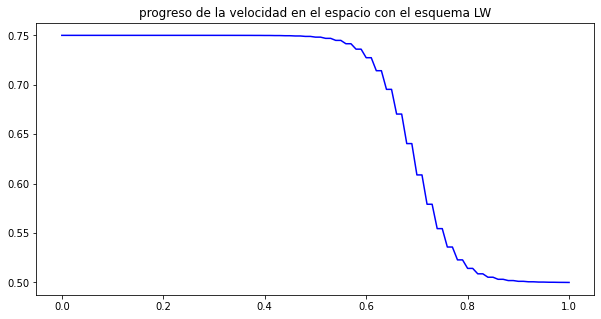

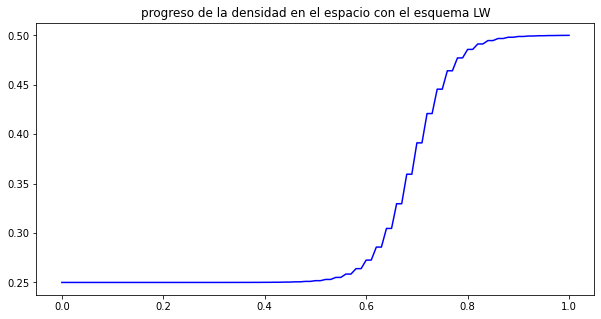

In [39]:
#calcular parametros
dx=0.01
dt=0.5*dx

a=0
b=1
ua=0.5
ub=0
N=int((1/dx)-1)
NT=int(2/dt)

def u0_continuo(x):
    if x<0.2:
        return 0.5
    else:
        return 0
    
#El f de la ec. de Burgers
def f(x):
    return (1/2)*x**2

x=np.arange(a,b+dx/2,dx)

#generar un vector con la condición inicial
u0=[]
for i in x:
    u0.append(u0_continuo(i))

x,ULF=resolver_ej2(f, a, b, ua, ub, dt, NT, N, u0, "LF")
x,ULW=resolver_ej2(f, a, b, ua, ub, dt, NT, N, u0, "LW")

#dada l solución espacial ARRAY en un tiempo fijo calcula la densidad en ese tiempo (V=D=1)
def densidad(ARRAY):
    return (1-ARRAY)/2

#dada l solución espacial ARRAY en un tiempo fijo calcula la velocidad en ese tiempo (V=D=1)
def velocidad(ARRAY):
    return (1+ARRAY)/2

#vel_o_dens: valore "densidad" o "velocidad" dependiendo de lo que se desee graficar
def animar_soluciones_ej2(x,ULF, ULW, dt, NT, N, esquema,vel_o_dens):
    """
    --------
    Input:
    - x: array
        Discretizacion de [0,1]
    - ULF, ULF: array
        Soluciones obtenidas con `resolver_ej2` con los metodos LF y LW respect.
    --------
    """
    
    fig = plt.figure(figsize = (10,5))
    #Definir parámetros de la figura
    
    #Inicializar animacion
    camera = Camera(fig)
    
    #Comenzar a graficar
    if esquema=="LF":
        A=ULF
    if esquema=="LW":
        A=ULW
    if vel_o_dens=="densidad":
        func=densidad
    if vel_o_dens=="velocidad":
        func=velocidad
    for n in range(NT+1):
        #Graficos
        plt.plot(x,func(ULF[:,n]),c="b")
        plt.title("progreso de la "+vel_o_dens+" en el espacio con el esquema "+ esquema)
        #Toma foto
        camera.snap()
    
    #Exportar animaciones
    anim = camera.animate(blit=False, interval=100)
    anim.save('discretizacion'+esquema+vel_o_dens+'.gif', writer='Pillow', fps=10)

#Graficar las velocidades y densidades de ambos esquemas    
animar_soluciones_ej2(x,ULF, ULW, dt, NT, N, "LF","velocidad")
animar_soluciones_ej2(x,ULF, ULW, dt, NT, N, "LF","densidad")
animar_soluciones_ej2(x,ULF, ULW, dt, NT, N, "LW","velocidad")
animar_soluciones_ej2(x,ULF, ULW, dt, NT, N, "LW","densidad")

Ahora, se modelará el efecto de un semáforo en rojo, el cual cambiará a verde en un par de segundos. Para ello, considere que el tramo de vía a modelar es el intervalo $\left[ 0,2\right] $.

Si existe un semáforo en $x=1$, nuestro dominio de interés para modelar el efecto de la luz roja mediante la ecuación de Burgers será el intervalo $\left[  0,1\right]  $. Suponga que los autos entran por $x=0$ a una velocidad constante, la cual se representará por $u\left(  t,0\right)  =u^{\ast}$. Por otra parte, los vehículos deben detenerse frente al semáforo, por lo que
$u(t,1)=-1$.

Además, se asume que todos los vehículos circulaban a una velocidad inicial constante $u\left(  0,x\right)  =u^{\ast}$ hasta que ven el semáforo en rojo. En el instante $t=T$ en que el semáforo cambia a verde, la densidad de vehículos es nula en $\omega_{2}=\left(  1,2\right]  $. Luego, $u(T,x)=1$, para $x\in\omega_{2}$.

### Ejercicio 3
Simule el efecto del semáforo que cambia de color rojo a verde.


**a.** Resuelva numéricamente la ecuación de Burgers para $t\in\left[0,2\right]  $ en el dominio $\omega_{1}=\left[  0,1\right]  $, considerando la condición inicial
$$
u\left(  0,x\right)  =\left\{
\begin{array}
[c]{cl}%
u^{\ast} & \text{si }0\leq x<1\\
-1 & \text{si }x=1
\end{array}
\right.
$$
y las condiciones de frontera $u\left(  t,0\right)  =u^{\ast}$ y $u(t,1)=-1$, con $u^{\ast}=0.25$. Para ello, use el esquema de Lax-Friedrichs con $\Delta x=0.002$ y $\Delta t=0.1\Delta x$, simulando un semáforo en rojo que dure $T=2$.


**b.** Resuelva numéricamente la ecuación de Burgers para $t\in\left[2,4\right]  $ y $\Omega=\omega_{1}\cup\omega_{2}=\left[  0,2\right]  $, considerando las condiciones de frontera $u\left(  t,0\right)  =u^{\ast}$ y $u(t,2)=1$, y la condición inicial dada por
$$
u\left(  2,x\right)  =\left\{
\begin{array}
[c]{cl}%
u_{R}\left(  2,x\right)   & \text{si }0\leq x\leq1\\
1 & \text{si }x>1
\end{array}
\right.
$$
donde $u_{R}\left(  2,x\right)  $ es la solución numérica resultante en el ejercicio anterior. Use los mismos parámetros y esquema que la parte anterior y grafique su solución solo en el conjunto $\omega_1$.

**c.** Interprete los resultados